In [3]:
#NeRF model architecture

'''
Components to the model:
1. Position encoding (finished)
2. Linear layer with ReLU activation function
3. Skip connection which adds the position encoding back in
4. Towards the end, the model splits into two sets of weights: One which maps to the sigma value (density), and one which which goes to rest of layers. This layer doesn't have an activation function
5. View encoding
6. At the last layer, in order to map to RGB, we use a sigmoid activation function
'''

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.init as init
import time
import numpy as np
import torch.nn.functional as F
import os
from tqdm import tqdm
from ipywidgets import interactive, widgets

# if not os.path.exists('tiny_nerf_data.npz'):
#     !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

import os
import requests

if not os.path.exists('NeRF_exp/tiny_nerf_data.npz'):
    print("Downloading tiny_nerf_data.npz...")
    url = "http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz"
    response = requests.get(url)
    with open('tiny_nerf_data.npz', 'wb') as f:
        f.write(response.content)
    print("Download complete.")

Download complete.


In [17]:
def encoding(x, L=10):
  res = [x]
  for i in range(L):
    for fn in [torch.sin, torch.cos]:
      res.append(fn(2 ** i * torch.pi * x))
  return torch.cat(res,dim=-1)

In [18]:
x = torch.Tensor([3.1,5.6,7.3])
y = encoding(x,L=4)
y.shape

torch.Size([27])

In [19]:
# import torch
# import torch.nn as nn
# import math
# class NeRF(nn.Module):
#     def __init__(self, D = 8, W = 256, input_ch = 60, input_ch_views = 24, skips = [4]):
#         super().__init__()
#         self.D = D
#         self.W = W
#         self.input_ch = input_ch
#         self.input_ch_views = input_ch_views
#         self.skips = skips

#         self.pts_linears = nn.ModuleList(
#             [nn.Linear(input_ch, W)] + 
#             [nn.Linear(W, W) if i not in skips else nn.Linear(W + input_ch, W) for i in range(D-1)]
#         )

#         #The split
#         self.sigma_linear = nn.Linear(W, 1) #going from 256 to 1

#         #Feature Vector
#         self.feature_linear = nn.Linear(W, W)   #Intermediate layers goes from 256 to 256

#         #View encoding
#         self.view_linear = nn.Linear(input_ch_views + W, W // 2)    #goes from viewing encoding + 256 to 128 

#         #RGB
#         self.rgb_linear = nn.Linear(W//2, 3)   #Going from 128 to 3
    
#     def forward(self, x, view_dirs):
#         h = x
#         for i, layer in enumerate(self.pts_linears):
#             if i in self.skips:
#                 h = torch.cat([h, x], dim = -1)
#             h = self.pts_linears[i](h)
#             h = torch.relu(h)
        
#         sigma = torch.relu(self.sigma_linear(h))
#         feature_vector = self.feature_linear(h)
#         color_input = torch.cat([feature_vector, view_dirs], dim=-1)
#         h_final = self.view_linear(color_input)
#         h_final = torch.relu(h_final)

#         rgb = torch.sigmoid(self.rgb_linear(h_final))
#         return rgb, sigma

class NeRF(nn.Module):
  def __init__(self, pos_enc_dim=63, view_enc_dim=27, hidden=256) -> None:
     super().__init__()

     self.linear1 = nn.Sequential(nn.Linear(pos_enc_dim,hidden),nn.ReLU())

     self.pre_skip_linear = nn.Sequential()
     for _ in range(4):
      self.pre_skip_linear.append(nn.Linear(hidden,hidden))
      self.pre_skip_linear.append(nn.ReLU())

     self.linear_skip = nn.Sequential(nn.Linear(pos_enc_dim+hidden,hidden),nn.ReLU())

     self.post_skip_linear = nn.Sequential()
     for _ in range(2):
      self.post_skip_linear.append(nn.Linear(hidden,hidden))
      self.post_skip_linear.append(nn.ReLU())

     self.density_layer = nn.Sequential(nn.Linear(hidden,1),nn.ReLU())

     self.linear2 = nn.Linear(hidden,hidden)

     self.color_linear1 = nn.Sequential(nn.Linear(hidden+view_enc_dim,hidden//2),nn.ReLU())
     self.color_linear2 = nn.Sequential(nn.Linear(hidden//2,3),nn.Sigmoid())

  def forward(self, input):

    positions = input[...,:3]
    view_dirs = input[...,3:]

    # Encode
    pos_enc = encoding(positions,L=10)
    view_enc = encoding(view_dirs,L=4)

    x = self.linear1(pos_enc)
    x = self.pre_skip_linear(x)

    # Skip connection
    x = torch.cat([x,pos_enc],dim=-1)
    x = self.linear_skip(x)

    x = self.post_skip_linear(x)

    # Density
    sigma = self.density_layer(x)

    x = self.linear2(x)

    # View Encoding
    x = torch.cat([x,view_enc],dim=-1)
    x = self.color_linear1(x)

    # Color Prediction
    rgb = self.color_linear2(x)

    return torch.cat([sigma,rgb],dim=-1)


In [ ]:
def get_rays(H, W, focal, c2w):
  """
  Generate rays for a given camera configuration.

  Args:
    H: Image height.
    W: Image width.
    focal: Focal length.
    c2w: Camera-to-world transformation matrix (4x4).

  Returns:
    rays_o: Ray origins (H*W, 3).
    rays_d: Ray directions (H*W, 3).
  """
  device = c2w.device
  focal = torch.from_numpy(focal).to(device)

  i, j = torch.meshgrid(
      torch.arange(W, dtype=torch.float32, device=device),
      torch.arange(H, dtype=torch.float32, device=device),
      indexing='xy'
  )
  dirs = torch.stack(
      [(i - W * .5) / focal, -(j - H * .5) / focal, -torch.ones_like(i, device = device)], -1
  )

  rays_d = torch.sum(dirs[..., None, :] * c2w[:3, :3], -1)
  rays_d = rays_d.view(-1, 3)
  rays_o = c2w[:3, -1].expand(rays_d.shape)

  return rays_o, rays_d

def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, device, rand=False, embed_fn=None, chunk=1024*4):
    def batchify(fn, chunk):
        return lambda inputs: torch.cat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)

    z_vals = torch.linspace(near, far, steps=N_samples, device=device)

    if rand:
        z_vals += torch.rand(*z_vals.shape[:-1], N_samples, device=rays_o.device) * (far - near) / N_samples

    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]

    view_dirs = rays_d / torch.norm(rays_d, dim=-1, keepdim=True)
    view_dirs = view_dirs[..., None, :].expand(pts.shape)

    input_pts = torch.cat((pts, view_dirs), dim=-1)
    raw = batchify(network_fn, chunk)(input_pts)

    sigma_a = raw[...,0]
    rgb = raw[...,1:]

    dists = z_vals[..., 1:] - z_vals[..., :-1]
    dists = torch.cat([dists, torch.tensor([1e10], device=device)], -1)

    alpha = 1. - torch.exp(-sigma_a * dists)
    alpha = alpha.unsqueeze(-1)

    ones_shape = (alpha.shape[0], 1, 1)
    T = torch.cumprod(
        torch.cat([
            torch.ones(ones_shape, device=device),
            1. - alpha + 1e-10
        ], dim=1),
        dim=1
    )[:, :-1]

    weights = alpha * T

    rgb_map = torch.sum(weights * rgb, dim=1)
    depth_map = torch.sum(weights.squeeze(-1) * z_vals, dim=-1)
    acc_map = torch.sum(weights.squeeze(-1), dim=-1)

    return rgb_map, depth_map, acc_map

In [21]:
def train(images,poses,H,W,focal,testpose,testimg,device):

    print(f"Using device: {device}")
    model = NeRF().to(device)

    criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(),lr=5e-4)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

    n_iter = 1000
    n_samples = 64
    i_plot = 50
    psnrs = []
    iternums = []
    t = time.time()

    # Convert data to tensors and move to device ONCE
    images_tensor = torch.from_numpy(images).float().to(device)
    poses_tensor = torch.from_numpy(poses).float().to(device)

    for i in range(n_iter):

        img_i = np.random.randint(images.shape[0])

        target = images_tensor[img_i]  # Use the corresponding image
        pose = poses_tensor[img_i]     # Use the corresponding pose

        rays_o, rays_d = get_rays(H, W, focal, pose)

        optimizer.zero_grad()

        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=n_samples, device=device, rand=True)

        rgb = rgb.reshape(H,W,3)

        loss = criterion(rgb, target)

        loss.backward()
        optimizer.step()

        if i % i_plot == 0:
            print(f'Iteration: {i}, Loss: {loss.item():.6f}, Time: {(time.time() - t) / i_plot:.2f} secs per iter')
            t = time.time()

            with torch.no_grad():
                rays_o, rays_d = get_rays(H, W, focal, testpose)
                rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6.,
                                           N_samples=n_samples, device=device)
                rgb = rgb.reshape(H, W, 3)
                loss = criterion(rgb, testimg)
                psnr = -10. * torch.log10(loss)

                psnrs.append(psnr.item())
                iternums.append(i)

                plt.figure(figsize=(10,4))
                plt.subplot(121)
                plt.imshow(rgb.cpu().detach())
                plt.title(f'Iteration: {i}')
                plt.subplot(122)
                plt.plot(iternums, psnrs)
                plt.title('PSNR')
                plt.show()

    return model

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


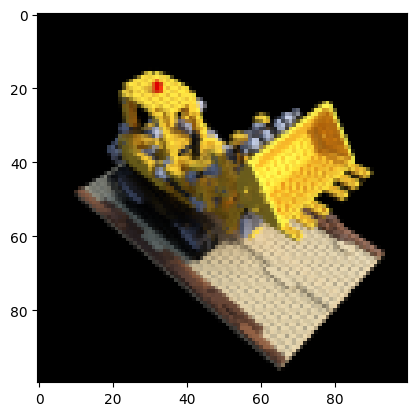

In [22]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)
device = "cuda" if torch.cuda.is_available() else "cpu"

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]
plt.imshow(testimg)
plt.show()
testimg =  torch.from_numpy(testimg).float().to("cuda")
testpose = torch.from_numpy(testpose).float().to("cuda")

Using device: cuda
Iteration: 0, Loss: 0.111756, Time: 0.02 secs per iter


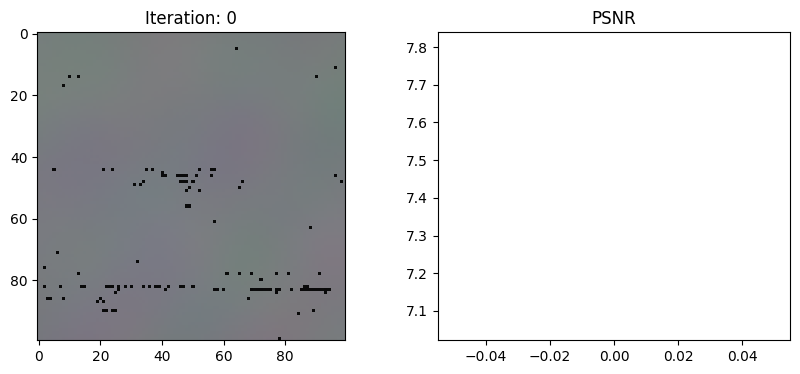

Iteration: 50, Loss: 0.125585, Time: 0.17 secs per iter


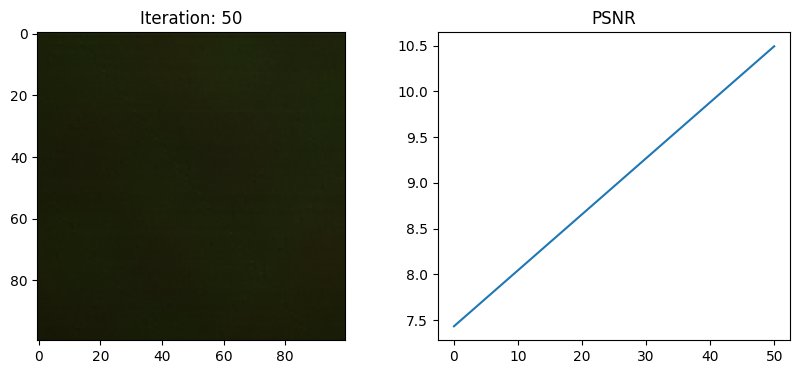

Iteration: 100, Loss: 0.042612, Time: 0.18 secs per iter


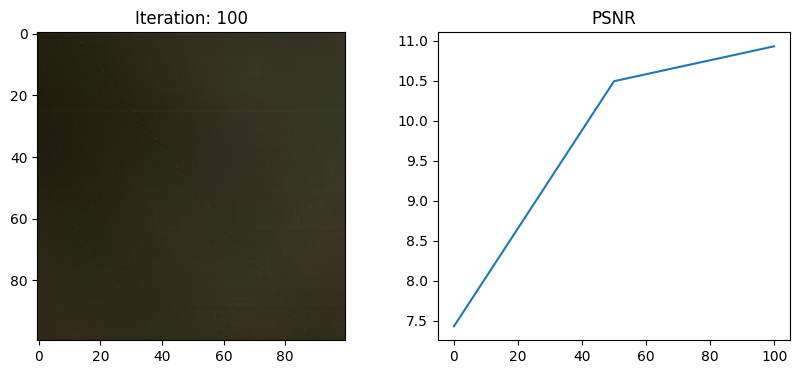

Iteration: 150, Loss: 0.100544, Time: 0.18 secs per iter


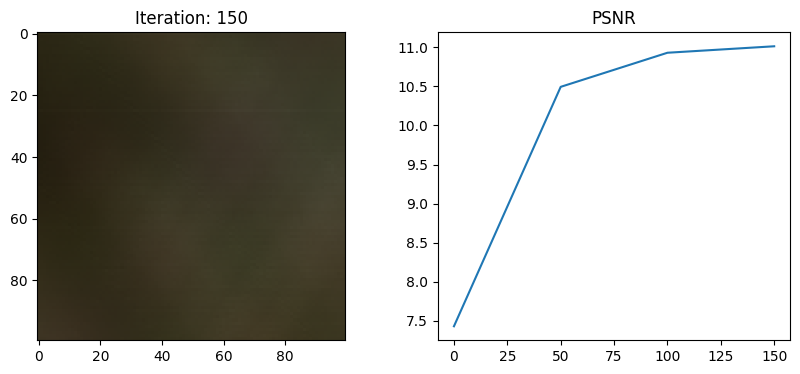

Iteration: 200, Loss: 0.079884, Time: 0.18 secs per iter


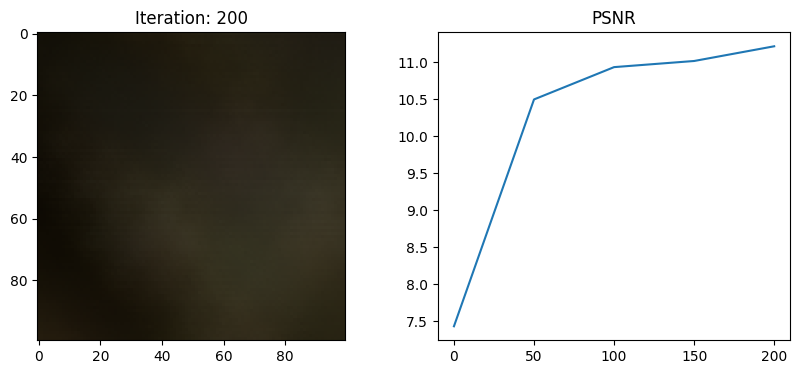

Iteration: 250, Loss: 0.023446, Time: 0.17 secs per iter


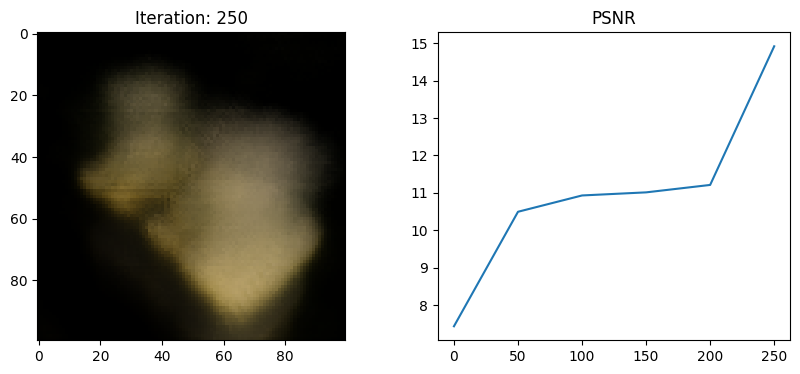

Iteration: 300, Loss: 0.011216, Time: 0.17 secs per iter


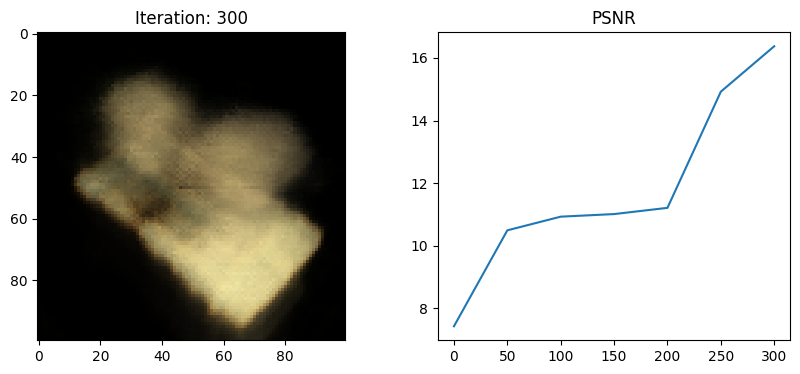

Iteration: 350, Loss: 0.021088, Time: 0.17 secs per iter


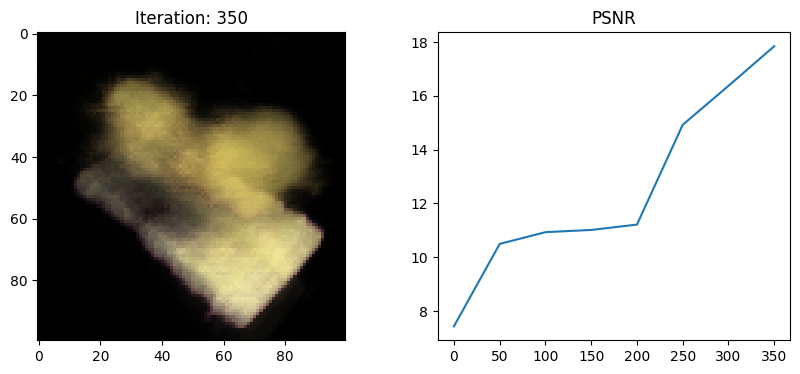

Iteration: 400, Loss: 0.006427, Time: 0.17 secs per iter


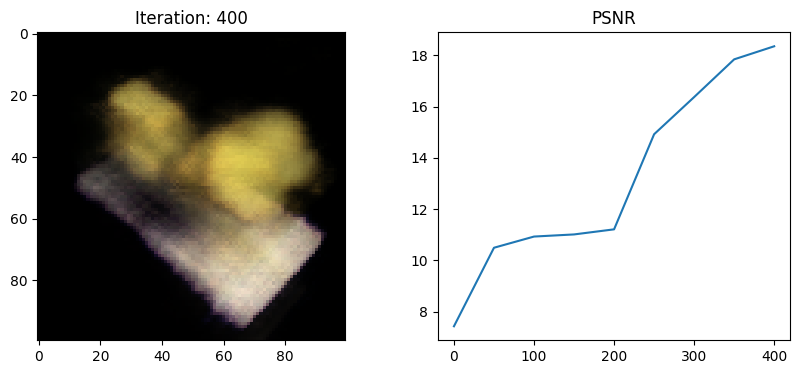

Iteration: 450, Loss: 0.017157, Time: 0.17 secs per iter


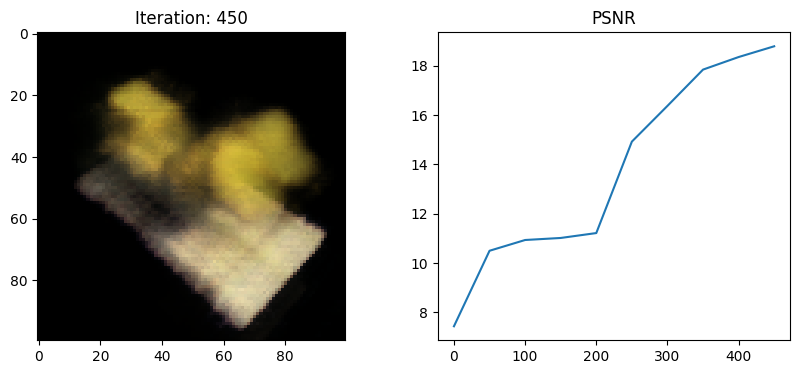

Iteration: 500, Loss: 0.006321, Time: 0.17 secs per iter


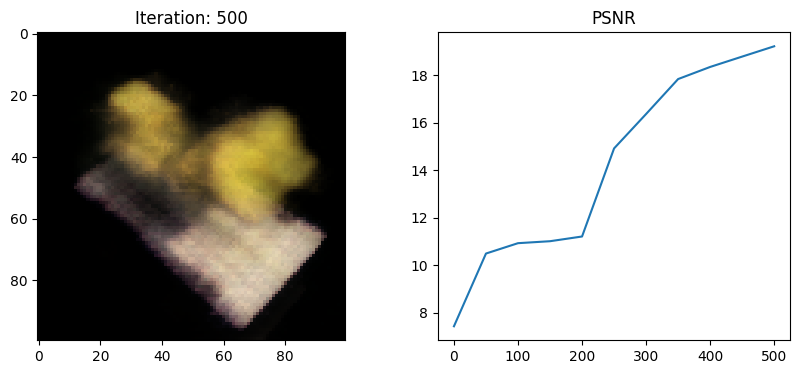

Iteration: 550, Loss: 0.007685, Time: 0.17 secs per iter


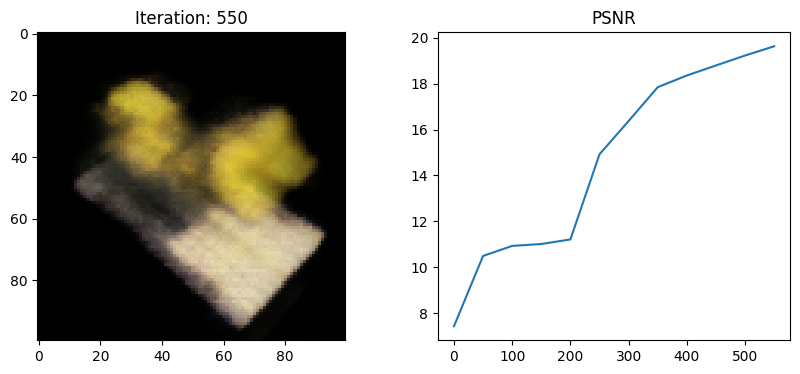

Iteration: 600, Loss: 0.012553, Time: 0.17 secs per iter


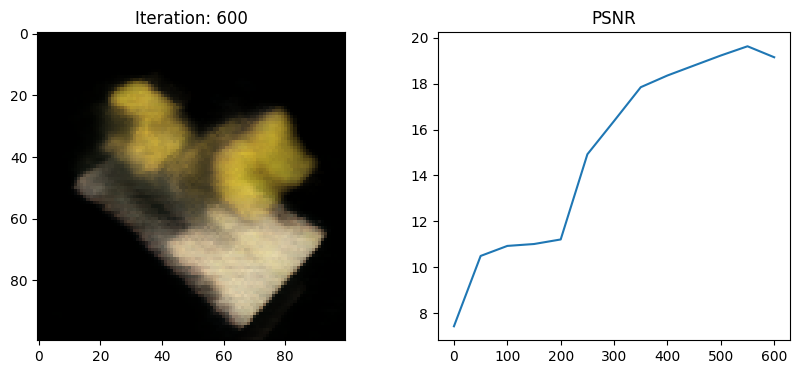

Iteration: 650, Loss: 0.010123, Time: 0.17 secs per iter


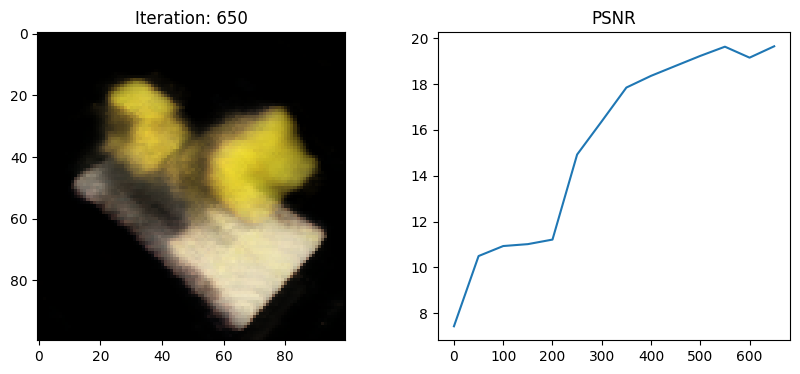

Iteration: 700, Loss: 0.010534, Time: 0.17 secs per iter


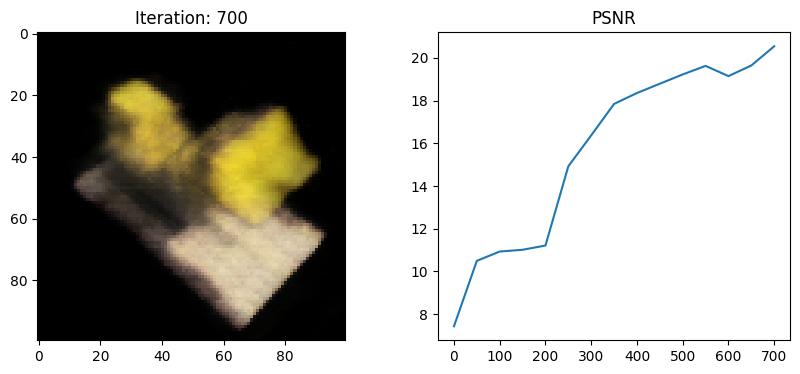

Iteration: 750, Loss: 0.009171, Time: 0.18 secs per iter


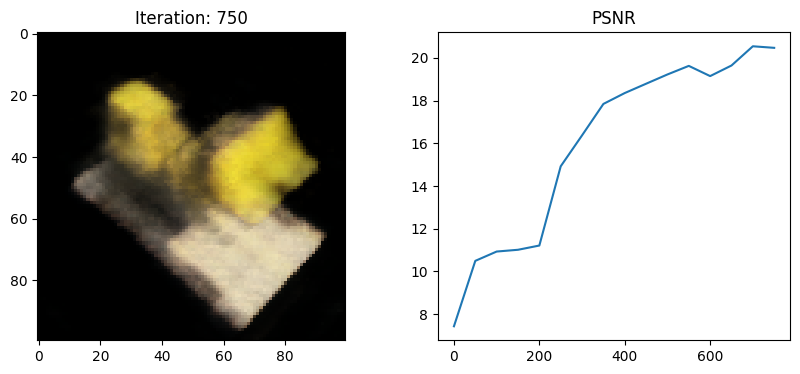

Iteration: 800, Loss: 0.005557, Time: 0.18 secs per iter


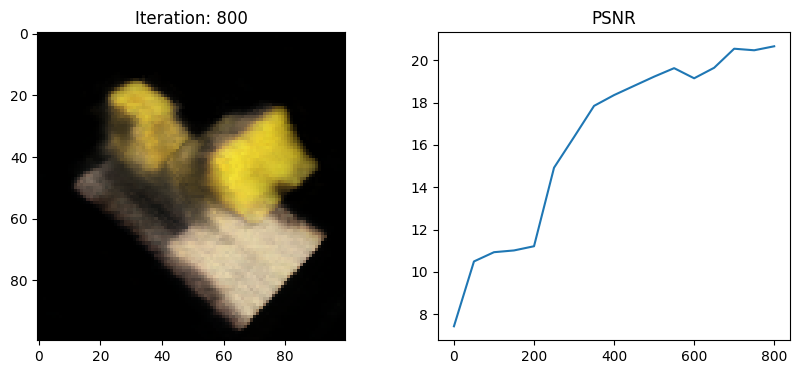

Iteration: 850, Loss: 0.009651, Time: 0.17 secs per iter


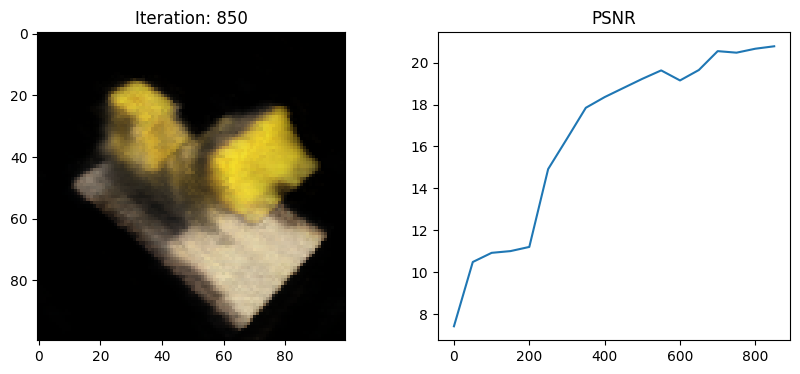

Iteration: 900, Loss: 0.009688, Time: 0.17 secs per iter


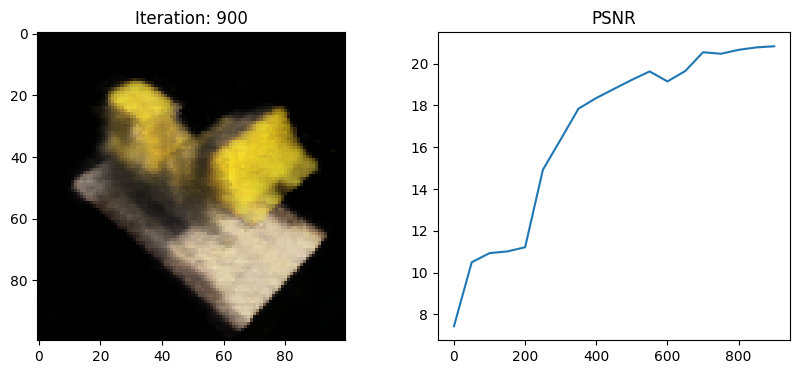

Iteration: 950, Loss: 0.008521, Time: 0.18 secs per iter


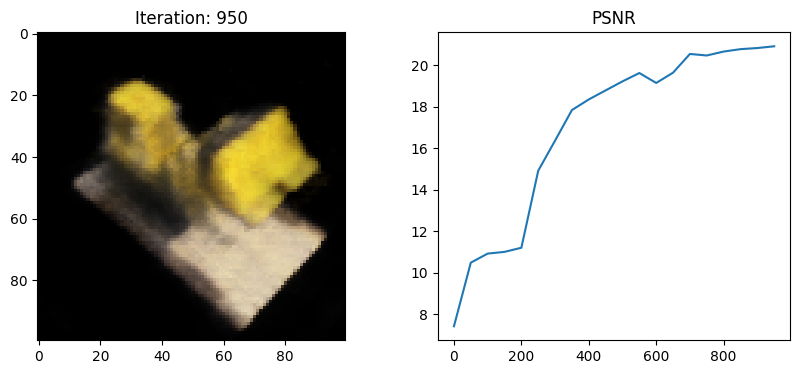

In [23]:
model = train(images,poses,H,W,focal,testpose,testimg,device)

In [25]:
# Transformation matrices in PyTorch
trans_t = lambda t: torch.tensor([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, t],
    [0, 0, 0, 1]
], dtype=torch.float32)

rot_phi = lambda phi: torch.tensor([
    [1, 0, 0, 0],
    [0, torch.cos(phi), -torch.sin(phi), 0],
    [0, torch.sin(phi), torch.cos(phi), 0],
    [0, 0, 0, 1]
], dtype=torch.float32)

rot_theta = lambda th: torch.tensor([
    [torch.cos(th), 0, -torch.sin(th), 0],
    [0, 1, 0, 0],
    [torch.sin(th), 0, torch.cos(th), 0],
    [0, 0, 0, 1]
], dtype=torch.float32)

# Pose function with spherical coordinates
def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = torch.matmul(rot_phi(torch.Tensor([phi / 180. * np.pi])), c2w)
    c2w = torch.matmul(rot_theta(torch.Tensor([theta / 180. * np.pi])), c2w)
    c2w = torch.tensor([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]], dtype=torch.float32) @ c2w
    return c2w

# Function for rendering based on user input
def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3, :4])  # Get rays (this is a placeholder)
    c2w, rays_o, rays_d = map(lambda t: t.to(device), (c2w, rays_o, rays_d))
    with torch.no_grad():
      rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=64, device=device)  # Render rays
    rgb = rgb.reshape(H, W, 3).cpu().detach()
    img = torch.clamp(rgb, 0, 1).numpy()  # Clamp RGB values between 0 and 1 and convert to numpy

    plt.figure(2, figsize=(20, 6))
    plt.imshow(img)
    plt.show()

# Interactive slider setup for theta, phi, and radius
sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0]: sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

In [27]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    c2w, rays_o, rays_d = map(lambda t: t.to(device), (c2w, rays_o, rays_d))
    with torch.no_grad():
      rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=64, device = device)
    rgb = rgb.reshape(H, W, 3)
    frames.append((255*np.clip(rgb.cpu().detach().numpy(),0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

100%|██████████| 120/120 [00:08<00:00, 13.96it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (100, 100) to (112, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [28]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)